In [1]:
"""Calcul et représentation des changements de genre dans l'expé prompt genrée
> pour un domaine pro/modèle/total, proportion du nb de fois où le genre du prompt n'a pas été respecté (M>F/A, F>M/A)/total"""

import pandas as pd
import numpy as np

modeles = ["cerbero-7b_genre_", "xglm-2"]

# Corpus global
dic_df = {}
for modele in modeles:
    df = pd.read_csv(f"ressources_it/it_coverletter_detection_it_coverletter_{modele}_gender_lg.csv")
    df["model"]=modele
    dic_df[modele] = df
    
data_genre = pd.concat(list(dic_df.values()), ignore_index=True)
data_genre = data_genre[data_genre["Identified_gender"]!="incomplet"]
data_genre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)
topics = list(set(data_genre["theme"]))


In [2]:
def prompt_gender(gender, df):
    """Renvoie la probabilité que le prompt ne soit pas respecté (= nb de fois où le texte est généré dans le genre opposé ou ambigu),
    par genre"""
    prompt_g = df[df['genre_prompt'].astype(str).str.contains(gender)]
    #return prompt_g["Identified_gender"].value_counts(normalize=True)
    pct = prompt_g["Identified_gender"].value_counts(normalize=True)
    if gender=="masc":
        opposite_gender="Feminine"
    else:
        opposite_gender="Masculine"

    return (pct.get('Ambiguous',0)+pct.get(opposite_gender,0))#*100 #%

## Résultats pour prompts masculins

In [3]:
# total
prompt_gender("masc", data_genre)

0.020146520146520144

In [4]:
# par modèle
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(prompt_gender("masc", data_model),2)
print(res_mod)

{'cerbero-7b_genre_': 0.02, 'xglm-2': 0.02}


In [5]:
# par domaine professionnel (tous et garder top 10 max et top 10 min)
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(prompt_gender("masc", data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
print("Domaines professionnels qui résultent en le + de générations fém/amb alors que le prompt est masc : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations fém/amb alors que le prompt est masc : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations fém/amb alors que le prompt est masc : 	 [('attività degli studi odontoiatrici', 0.17), ('attività delle agenzie di viaggio', 0.1), ('traduzione e interpretariato', 0.09), ('attività generali di amministrazione pubblica', 0.09), ('affari esteri', 0.08), ('servizi degli studi medici di medicina generale', 0.08), ('attività di musei', 0.08), ('attività delle banche centrali', 0.08), ('installazione di impianti elettrici', 0.08), ('costruzione di ponti e gallerie', 0.08)]


Domaines professionnels qui résultent en le - de générations fém/amb alors que le prompt est masc : 	 [('ordine pubblico e sicurezza nazionale', 0), ('fabbricazione di veicoli militari da combattimento', 0), ('riparazione di computer e periferiche', 0), ('attività di pulizia', 0), ('realizzazione di coperture', 0), ('commercio di altri autoveicoli', 0), ('attività dei vigili del fuoco e della protezione civile', 0), ('ricerca e sviluppo sperimentale nel campo

## Résultats pour prompts féminins

In [6]:
# total
prompt_gender("fem", data_genre)

0.1853146853146853

In [7]:
# par modèle
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(prompt_gender("fem", data_model),2)
print(res_mod)

{'cerbero-7b_genre_': 0.25, 'xglm-2': 0.12}


In [8]:
# par domaine professionnel (tous et garder top 10 max et top 10 min)
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(prompt_gender("fem", data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
print("Domaines professionnels qui résultent en le + de générations masc/amb alors que prompt fém : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations masc/amb alors que prompt fém : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations masc/amb alors que prompt fém : 	 [('servizi veterinari', 0.45), ('servizi degli studi medici di medicina generale', 0.45), ('pesca marina', 0.45), ('fusione di acciaio', 0.42), ('fabbricazione di strumenti musicali', 0.42), ('allevamento di bovini da latte', 0.36), ('lavori di costruzione e installazione', 0.33), ('attività delle banche centrali', 0.33), ('commercio di altri autoveicoli', 0.33), ('attività generali di amministrazione pubblica', 0.27)]


Domaines professionnels qui résultent en le - de générations masc/amb alors que prompt fém : 	 [('attività editoriali', 0.08), ('servizi di asili nido', 0.08), ('fabbricazione di profumi e cosmetici', 0.08), ('servizi di assistenza sanitaria', 0.08), ('ricerca e sviluppo sperimentale nel campo delle scienze sociali e umanistiche', 0.08), ('traduzione e interpretariato', 0), ('servizi investigativi privati', 0), ('attività degli studi odontoiatrici', 0), ('ordine pubblico e si

## Résultats globaux (all gender shifts, prompt pas respecté dans un sens ou dans l'autre)

In [9]:
def gender_shift(df):
    """Renvoie la probabilité que le prompt ne soit pas respecté (= nb de fois où le texte est généré dans le genre opposé ou ambigu)"""
    #df.replace({"['Prompt_masc']":"Masculine", "['Prompt_fém']":"Feminine"}, inplace=True)

    # compte les gender shift du neutre vers autre chose = 25% de gender shift
    df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['genre_prompt'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
    
    # exclusion du neutre
    df = df[df.genre_prompt != "Neutral"]
    df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)

    df.to_csv("gender_shift_noneutral_it.csv")
    return sum(df['gender_shift'])/len(df['gender_shift'])

In [10]:
# TODO : CORRIGER... DEVRAIT ÊTRE 10.46

In [11]:
"""Attention, prompts inclusifs exclus"""
data_genre.replace({"masc":"Masculine", "fem":"Feminine", "inclus":"Neutral"}, inplace=True)
gender_shift(data_genre)

/tmp/ipykernel_294877/2760744857.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)


0.10465116279069768

In [12]:
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(gender_shift(data_model),3)
print(res_mod)

{'cerbero-7b_genre_': 0.135, 'xglm-2': 0.069}


/tmp/ipykernel_294877/2760744857.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['genre_prompt'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
/tmp/ipykernel_294877/2760744857.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_g

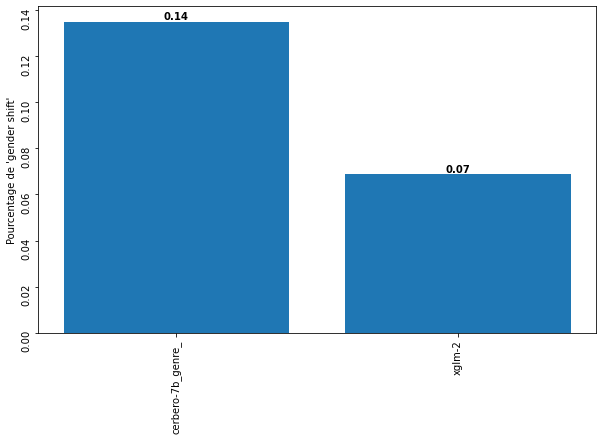

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(res_mod.keys()), list(res_mod.values()))
ax.tick_params(labelrotation=90) 
ax.set_ylabel("Pourcentage de 'gender shift'")
#ax.set_title('Problèmes de qualité de données')
i = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             round(list(res_mod.values())[i],2),
             ha='center',
             weight='bold')
    i+=1
    
#plt.savefig("fig/moy_gap_topic_model.png")

In [14]:
# par domaine professionnel (tous et garder top 10 max et top 10 min)
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(gender_shift( data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
print("Domaines professionnels qui résultent en le + de générations avec chgt de genre : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations avec chgt de genre : \t", top[-10:])

/tmp/ipykernel_294877/2760744857.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['genre_prompt'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
/tmp/ipykernel_294877/2760744857.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_g

Domaines professionnels qui résultent en le + de générations avec chgt de genre : 	 [('servizi degli studi medici di medicina generale', 0.26), ('fabbricazione di strumenti musicali', 0.24), ('servizi veterinari', 0.22), ('pesca marina', 0.22), ('fusione di acciaio', 0.21), ('attività delle banche centrali', 0.21), ('lavori di costruzione e installazione', 0.18), ('attività generali di amministrazione pubblica', 0.18), ('allevamento di bovini da latte', 0.18), ('commercio di altri autoveicoli', 0.17)]


Domaines professionnels qui résultent en le - de générations avec chgt de genre : 	 [('servizi di assistenza sanitaria', 0.05), ('ricerca e sviluppo sperimentale nel campo delle scienze sociali e umanistiche', 0.05), ('attività degli studi legali e notarili', 0.05), ('attività editoriali', 0.04), ('traduzione e interpretariato', 0.04), ('telecomunicazione', 0.04), ('realizzazione di coperture', 0.04), ('servizi investigativi privati', 0.0), ('ordine pubblico e sicurezza nazionale', 0.0)

In [16]:
# ESSAI PAR MODELE + par domaine professionnel (tous et garder top 10 max et top 10 min)
res_dom = {}
data_model = data_genre[data_genre['model']=="cerbero-7b_genre_"]
for topic in topics:
    data_topic = data_model[data_model['theme']==topic]
    res_dom[topic] = round(gender_shift( data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
print("Domaines professionnels qui résultent en le + de générations avec chgt de genre : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations avec chgt de genre : \t", top[-10:])

/tmp/ipykernel_294877/2760744857.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['genre_prompt'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
/tmp/ipykernel_294877/2760744857.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_g

Domaines professionnels qui résultent en le + de générations avec chgt de genre : 	 [('fusione di acciaio', 0.33), ('pesca marina', 0.33), ('attività delle banche centrali', 0.33), ('fabbricazione di strumenti musicali', 0.33), ('attività generali di amministrazione pubblica', 0.25), ('attività delle agenzie di viaggio', 0.25), ('giustizia ed attività giudiziarie', 0.25), ("attività dei servizi connessi alle tecnologie dell'informatica", 0.25), ('edizione di giochi per computer', 0.25), ('allevamento di bovini da latte', 0.25)]


Domaines professionnels qui résultent en le - de générations avec chgt de genre : 	 [('fabbricazione di veicoli militari da combattimento', 0.08), ('attività di pulizia', 0.08), ('realizzazione di coperture', 0.08), ('ricerca e sviluppo sperimentale nel campo delle biotecnologie', 0.08), ('servizi investigativi privati', 0.0), ('ricerche di mercato e sondaggi di opinione', 0.0), ('attività degli studi legali e notarili', 0.0), ('ordine pubblico e sicurezza naz

In [17]:
# ESSAI PAR MODELE + par domaine professionnel (tous et garder top 10 max et top 10 min)
res_dom = {}
data_model = data_genre[data_genre['model']=="xglm-2"]
for topic in topics:
    data_topic = data_model[data_model['theme']==topic]
    res_dom[topic] = round(gender_shift( data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
print("Domaines professionnels qui résultent en le + de générations avec chgt de genre : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations avec chgt de genre : \t", top[-10:])

/tmp/ipykernel_294877/2760744857.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['genre_prompt'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
/tmp/ipykernel_294877/2760744857.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre_prompt'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_g

Domaines professionnels qui résultent en le + de générations avec chgt de genre : 	 [('servizi degli studi medici di medicina generale', 0.36), ('servizi veterinari', 0.27), ('ricerche di mercato e sondaggi di opinione', 0.22), ('lavori di costruzione e installazione', 0.2), ('fabbricazione di aeromobili', 0.2), ('servizi ospedalieri', 0.18), ('attività di musei', 0.17), ('attività di produzione cinematografica, di video e di programmi televisivi', 0.14), ('attività fotografiche', 0.11), ("consulenza nel settore delle tecnologie dell'informatica", 0.11)]


Domaines professionnels qui résultent en le - de générations avec chgt de genre : 	 [('rappresentazioni artistiche', 0.0), ('ricerca e sviluppo sperimentale nel campo delle scienze sociali e umanistiche', 0.0), ("attività dei servizi connessi alle tecnologie dell'informatica", 0.0), ('edizione di giochi per computer', 0.0), ('ordine pubblico e sicurezza nazionale', 0.0), ('riparazione di computer e periferiche', 0.0), ('realizzazione

In [ ]:
df_top = pd.DataFrame(top[:10]+top[-10:], columns =['Field', 'Gender shift prob'])

In [ ]:
import seaborn as sns
ax = sns.lineplot(data=df_top, x="Field", y="Gender shift prob", )
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0.0, 1.0)